<a href="https://colab.research.google.com/github/mardom/SadoskyCV/blob/main/Pr%C3%A1ctica_1_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Práctica 1: Clasificación de imágenes con un perceptrón multicapa (MLP)

En esta práctica aprenderemos a trabajar con imágenes y entrenaremos un **perceptrón multicapa** (MLP) para reconocer dígitos manuscritos.

---

### Bibliotecas y entorno de trabajo

Primero, importamos las **bibliotecas** que vamos a necesitar para trabajar con imágenes y redes neuronales.

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from collections import Counter
from sklearn.metrics import confusion_matrix

Definimos el **dispositivo** que vamos a usar para hacer los cálculos. Si la GPU está disponible, la usamos; si no, elegimos la CPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo a utilizar: {device}")

Dispositivo a utilizar: cuda


### Dataset MNIST

**MNIST** es uno de datasets más conocidos para tareas de clasificación de imágenes.

El mismo contiene unas 60.000 imágenes de entrenamiento y 10.000 de prueba.

Las imágenes son en escala de grises de 28x28 píxeles de tamaño y cada representa un dígito escrito a mano, del 0 al 9.


Para empezar, vamos a descargar todo el dataset y luego lo vamos a dividirlo en tres conjuntos:
- **Entrenamiento**: datos para entrenar el modelo.
- **Validación**: datos para monitorear el rendimiento del modelo durante el entrenamiento.
- **Prueba**: datos para medir el desempeño del modelo entrenado con datos nuevos.

In [3]:
# Transformación para convertir una imagen a tensor y las intensidades al rango [0, 1]
transform = transforms.ToTensor()

# Descargamos el dataset
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform)

# Dividimos el conjunto de entrenamiento en 80% para entrenamiento y 20% para validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Creamos los dataloaders para cargar los datos por lotes (batches)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"\nTamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de validación: {len(val_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.45MB/s]


Tamaño del conjunto de entrenamiento: 48000
Tamaño del conjunto de validación: 12000
Tamaño del conjunto de prueba: 10000


Veamos algunas imágenes del conjunto de entrenamiento junto con sus etiquetas.

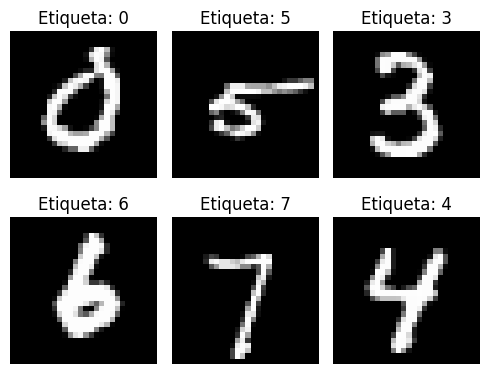

In [4]:
# Seleccionamos 6 índices aleatorios del conjunto de entrenamiento
random_indices = random.sample(range(len(train_dataset)), 6)

plt.figure(figsize=(5, 4))

for i, idx in enumerate(random_indices):
    image, target = train_dataset[idx]

    plt.subplot(2, 3, i + 1)
    plt.imshow(image[0], cmap="gray")
    plt.title(f"Etiqueta: {target}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Ahora veamos cómo están distribuídas las clases en el conjunto de entrenamiento.

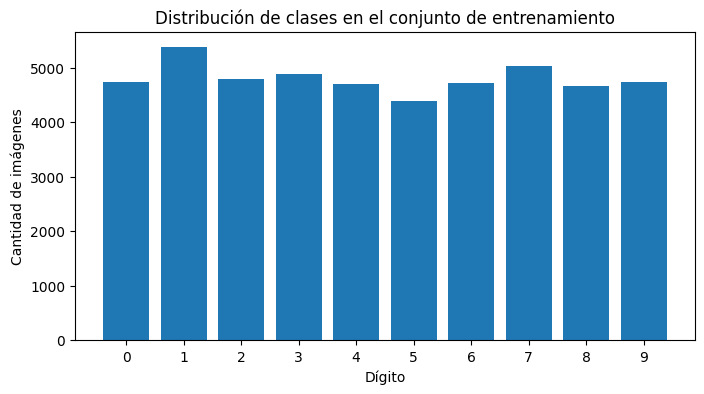

In [5]:
# Obtenemos las etiquetas y contamos cuántas veces aparece cada clase
labels = [label for _, label in train_dataset]
class_counts = Counter(labels)

sorted_counts = dict(sorted(class_counts.items()))

plt.figure(figsize=(8, 4))
plt.bar(sorted_counts.keys(), sorted_counts.values())
plt.xlabel("Dígito")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xticks(range(10))
plt.show()

Como todas las clases tienen aproximadamente la misma cantidad de imágenes, podemos decir que el conjunto está **balanceado**.

### Perceptrón multicapa (MLP)

Ahora vamos a construir una red neuronal sencilla que luego entrenaremos para que aprenda a reconocer los dígitos.

Utilizaremos un tipo de red neuronal **"feedforward" totalmente conectada**, conocida como **perceptrón multicapa** (MLP).

Nuestro MLP tendrá tres capas:
- Una **capa de entrada** de 784 unidades (porque cada imagen es de 28x28 píxeles → 28 x 28 = 784).
- Una **capa oculta** de 32 unidades con función de activación ReLU.
- Una **capa de salida** con 10 unidades (una unidad para cada dígito del 0 al 9).

In [27]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Definimos las capas de la red
        self.fc1 = nn.Linear(784, 32, bias=True)
        self.fc2 = nn.Linear(32, 10, bias=True)

    def forward(self, x):
        # Implementamos la pasada hacia adelante
        x = x.view(-1, 784)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

### Entrenamiento y evaluación

Una vez definida la red, tenemos que **entrenarla** con ejemplos (imágenes y sus etiquetas), y luego **evaluar** su rendimiento.

Para ello, vamos a implementar dos funciones; `train` y `evaluate`.

La función `train` **entrena** el modelo durante una **época** utilizando el **conjunto de entrenamiento**.

Recordemos que las épocas son las repeticiones o "pasadas" sobre el conjunto de entrenamiento.

In [8]:
def train(model, criterion, optimizer, train_loader, device):
    # Ponemos el modelo en modo entrenamiento
    model.train()

    total_loss = 0

    # Recorremos los datos de entrenamiento por batches
    for batch in train_loader:

        # Obtenemos imágenes y etiquetas
        images, targets = batch[0], batch[1]
        images, targets = images.to(device), targets.to(device)

        # Pasada hacia adelante
        outputs = model(images)

        # Calculamos la pérdida
        loss = criterion(outputs, targets)

        # Limpiamos gradientes, aplicamos backpropagation y actualizamos los pesos
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Pérdida promedio
    train_loss = total_loss / len(train_loader)

    return train_loss

La función `evaluate` **evalúa** el modelo en el **conjunto de validación** y calcula el **porcentaje de aciertos** (precisión o *accuracy*).

In [21]:
def evaluate(model, criterion, val_loader, device):
    # Ponemos el modelo en modo evaluación
    model.eval()

    total_loss = 0
    correct = 0
    total = 0

    all_predictions = []
    all_targets = []

    # Desactivamos el cálculo de gradientes
    with torch.no_grad():

        # Recorremos los datos de validación por batches
        for batch in val_loader:
            images, targets = batch[0], batch[1]
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            total_loss += loss.item()

            # Predicciones: elegimos la clase con mayor score
            predictions = outputs.argmax(dim=1)

            # Contamos las predicciones correctas
            correct += (predictions == targets).sum().item()
            total += len(targets)

            # Guardamos predicciones y salidas correctas para visualizar luego
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Pérdida promedio
    test_loss = total_loss / len(val_loader)

    # Porcentaje de aciertos
    test_acc = correct / total * 100

    return test_loss, test_acc, all_predictions, all_targets

### Entrenamos el MLP

Ahora vamos a proceder con el **entrenamiento** de la red neuronal.

Para ello, **inicializamos** nuestro MLP y lo movemos al dispositivo (GPU o CPU).

Luego definimos la **función de pérdida** (para medir el error) y el **método de optimización** (para ajustar los pesos).

La función de pérdida que utilizaremos para calcular el error de la red será la **entropía cruzada**.

En cuanto al método de optimización, usaremos el **descenso por gradiente estocástico** (SGD) con una **tasa de aprendizaje** de 0.01.

In [28]:
model = MLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


Entrenamos el modelo durante **20 épocas** y registramos la pérdida y la precisión en cada época.

In [29]:
num_epochs = 20

train_losses = []
val_losses = []
val_accuracies = []

# Ciclo de entrenamiento
for epoch in range(num_epochs):
    # Entrenamos el modelo una época completa
    train_loss = train(model, criterion, optimizer, train_loader, device)

    # Evaluamos el modelo en el conjunto de validación
    val_loss, val_acc, _, _ = evaluate(model, criterion, val_loader, device)

    # Guardamos los resultados de esta época
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoca {epoch+1}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}, Val acc = {val_acc:.2f}%")

Epoca 1: Train loss = 1.4261, Val loss = 0.7449, Val acc = 83.83%
Epoca 2: Train loss = 0.5816, Val loss = 0.4860, Val acc = 87.84%
Epoca 3: Train loss = 0.4405, Val loss = 0.4076, Val acc = 89.23%
Epoca 4: Train loss = 0.3867, Val loss = 0.3702, Val acc = 89.87%
Epoca 5: Train loss = 0.3571, Val loss = 0.3493, Val acc = 90.33%
Epoca 6: Train loss = 0.3374, Val loss = 0.3319, Val acc = 90.80%
Epoca 7: Train loss = 0.3227, Val loss = 0.3190, Val acc = 90.92%
Epoca 8: Train loss = 0.3107, Val loss = 0.3090, Val acc = 91.27%
Epoca 9: Train loss = 0.3005, Val loss = 0.3007, Val acc = 91.37%
Epoca 10: Train loss = 0.2918, Val loss = 0.2928, Val acc = 91.73%
Epoca 11: Train loss = 0.2836, Val loss = 0.2860, Val acc = 91.83%
Epoca 12: Train loss = 0.2762, Val loss = 0.2795, Val acc = 92.05%
Epoca 13: Train loss = 0.2691, Val loss = 0.2739, Val acc = 92.12%
Epoca 14: Train loss = 0.2627, Val loss = 0.2680, Val acc = 92.22%
Epoca 15: Train loss = 0.2563, Val loss = 0.2620, Val acc = 92.50%
Epoc

### Visualizamos el entrenamiento

Veamos en un gráfico cómo evoluciona la pérdida y la precisión a lo largo de las épocas para monitorear si el modelo está aprendiendo bien.

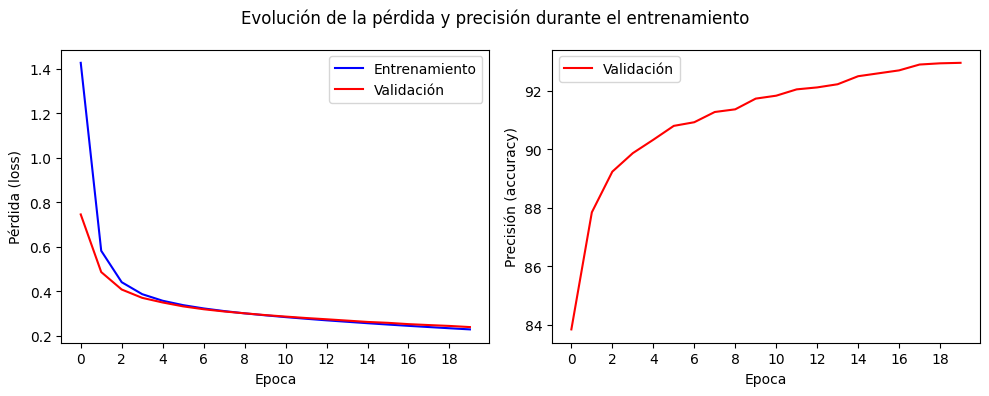

In [30]:
plt.figure(figsize=(10, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Entrenamiento", color="blue")
plt.plot(val_losses, label="Validación", color="red")
plt.xlabel("Epoca")
plt.ylabel("Pérdida (loss)")
plt.xticks(range(0, num_epochs, 2))
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validación", color="red")
plt.xlabel("Epoca")
plt.ylabel("Precisión (accuracy)")
plt.xticks(range(0, num_epochs, 2))
plt.legend()

plt.suptitle("Evolución de la pérdida y precisión durante el entrenamiento")
plt.tight_layout()
plt.show()

Si la pérdida baja con las épocas y la precisión sube, entonces el modelo está aprendiendo bien.

En cambio, si la pérdida en validación empieza a subir mientras la de entrenamiento sigue bajando, podría haber sobreajuste.

### Evaluación final del modelo

Si todo salió bien, ahora es momento de probar el modelo entrenado en el **conjunto de prueba**.

Recordemos que este conjunto contiene imágenes que la red no vió durante el entrenamiento.

Este paso nos permitirá saber qué tan bien **generaliza** nuestro modelo a datos nuevos.

In [ ]:
_, test_acc, predictions, targets = evaluate(..., criterion, ..., device)
print(f"Precisión del MLP en el conjunto de prueba: {test_acc:.2f}%")

Ahora veamos más en detalle cómo se distribuyen las predicciones de la red en cada una de las clases:

In [ ]:
# Calculamos la matriz de confusión
cm = confusion_matrix(targets, predictions)

class_names = [str(i) for i in range(10)]

plt.figure(figsize=(6, 5))

plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Matriz de confusión")
plt.colorbar()

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(cm[i, j], "d"), ha="center", va="center",
                 color="white" if i == j else "black")

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.show()

---

### Recursos

- [Tutorial de PyTorch](https://docs.pytorch.org/tutorials/beginner/basics/intro.html)
- [Tutorial de Matplotlib](https://matplotlib.org/stable/tutorials/index.html)
- [Tutorial de NumPy](https://numpy.org/doc/stable/user/absolute_beginners.html)
- [Tutorial de Python](https://docs.python.org/3.13/tutorial/index.html)